<a href="https://colab.research.google.com/github/Alberto-San/ExperimentosMonografia/blob/main/Master_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descargando APIS

Esta seccion contiene el codigo necesario para correr las diferentes funcionalidades que se reportaran a lo largo del notebook:
* Obtencion de Caracteristicas por imagen
* Reconocimiento de datos atipicos
* Filtrado de datos atipicos
* ...

In [1]:
!git clone https://github.com/Alberto-San/MonografiaDataScience

Cloning into 'MonografiaDataScience'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 130 (delta 45), reused 108 (delta 29), pack-reused 0
Receiving objects: 100% (130/130), 21.13 MiB | 22.83 MiB/s, done.
Resolving deltas: 100% (45/45), done.


# Condiciones
Estas banderas permiten definir el estado de desarrollo del experimento.
* IS_ZIP_EXTRACTED: si esta bandera es ```True```, significa que el dataset ya fue cargado y procesado
* IS_FEATURES_EXTRACTED: si esta bandera es ```True```, significa que ya se extrajeron las caracteristicas de las imagenes

In [9]:
IS_ZIP_EXTRACTED = True
IS_FEATURES_EXTRACTED = True
IS_OUTLIERS_EXTRACTED = True

# Funciones Base

En esta seccion se reportan funciones generales que se usaran a lo largo del experimento
* ```cd_into```: permite agregar al path del sistema el folder para reconocer los diferentes modulos que se usaran a lo largo del experimento

In [3]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

def cd_into(folder):
  sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), folder)))

# Descargando las imagenes
Se descarga el dataset de **sipakmed**, el cual, contiene recortes que son las imagenes objetivos, separados en 5 grandes categorias:
* K
* S
* M
* D
* P

In [4]:
cd_into("MonografiaDataScience/DownloadAPI")

if not IS_ZIP_EXTRACTED:
  from download_api import *

  dataset_name = "prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed"
  kaggle_key = '{"username":"daniellpez2","key":"d2901f7891215e2c88e8defcd26c7c8c"}'
  dst_folder = "sipakmed"

  downloader = DownloadDataset(dataset_name, kaggle_key, dst_folder)
  measure_time(downloader.download)

# Obteniendo vectores de caracteristicas

Se sigue el procedimiento de <<citar persona>> reportado en el paper <<citar paper>>, y se extraen las caracteristicas de :
* Intensidad promedio: Se define como la media de la imagen
* Suavidad: Se define como el promedio del valor absoluto de la imagen al aplicar un filtro laplaciano
* Uniformidad: Se define como las suma de las diferencias al cuadrado entre la imagen al aplicar un filtro guassiano, y la imagen al aplicar multiples veces el filtro gaussiano
* Tercer Momento: Se define como el tercer momento de la distribucion de la imagen como vector. 
* Entropia: Se define como la entropia de shannon al considerar la distribucion de frecuencias de la imagen como distribucion de probabilidad
* Desviacion estandar: Se define como la desviacion estandar de la imagen
* Mediana: Se define como la mediana de la imagen
* Contraste promedio: Se define como la media de la luminancia de la imagen

en cada una de las dimensiones (R, G, B) de las imagenes.

In [5]:
import pandas as pd

cd_into("MonografiaDataScience/FeaturesAPI/Experiment_color")

csv_files = [file for file in os.listdir("MonografiaDataScience/tmp/") if file.split(".")[-1] == "csv"]


if len(csv_files) < 1 and (not IS_FEATURES_EXTRACTED):
  import cv2
  
  import cv2
  from scipy.stats import moment
  from CervicalCancerContentReader import *
  from CalculateImageClasicalFeatures import *
  from constants import *
  import multiprocessing

  sub_folder = "CROPPED"
  image_extension = "bmp"
  data_extension = "dat"
  dataset_output_path = "/content/sipakmed"
  size = (220, 220)

  categories_content = CervicalCancerContentReader(
                          dataset_output_path,
                          image_extension,
                          data_extension,
                          sub_folder
                      ).read()

  labels = list(categories_content.keys())


  def multiprocessing_logic(items, function):
      num_processes = multiprocessing.cpu_count()
      pool = multiprocessing.Pool(num_processes)
      output_list = pool.map(function, items)
      return output_list

  def get_color_component(path):
      print("path: {}".format(path))
      image_bgr = cv2.imread(path)
      color_component = cv2.resize(image_bgr, size, interpolation=cv2.INTER_LINEAR)
      return color_component

  def get_descriptor(args):
      index, label, image_paths, image_component, hanlder = args
      return [label, image_paths[index]] + hanlder.calculate_features(image_component)

  def calculate_features_label(label, categories_content):
      hanlder = CalculateImageClasicalFeatures("bgr")
      image_paths = categories_content[label][IMAGE_PATH_KEY]
      num_processes = multiprocessing.cpu_count()
      pool = multiprocessing.Pool(num_processes) #[get_luminance_component(path) for path in image_paths]
      print("Reading Images")
      im_list = pool.map(get_color_component, image_paths) #pool.map(get_luminance_component, image_paths)
      function_args = [(index, label, image_paths, im_list[index], hanlder) for index in range(len(im_list))]
      print("Getting Descriptors")
      features = pool.map(get_descriptor, function_args) #multiprocessing_logic(items=function_args, function=get_descriptor)
      return features

  accum_list = []
  accum_labels = []
  flag_define_labels = False
  for label in labels:
      [accum_list.append(feature) for feature in calculate_features_label(label, categories_content)]

      if not(flag_define_labels):
          accum_labels = ["feature_{}".format(index) for index in range(len(accum_list[0])-2)]
          flag_define_labels = True
      

  columns = [
      "class",
      "image_path"
      ] + accum_labels
  df = pd.DataFrame(accum_list, columns=columns)

  df.to_csv("./MonografiaDataScience/tmp/color_statistics.csv", index=False)

Se muestra un ejemplo de un registro, donde hay 7 caracteristicas por cada uno de los canales R,G,B (21 en total), y una adicional correspondiente a la luminancia

In [6]:
path_color_images = "./MonografiaDataScience/tmp/color_statistics.csv"
table_features = pd.read_csv(path_color_images)
table_features.head(1).transpose()

,0
class,im_Superficial-Intermediate
image_path,/content/sipakmed/im_Superficial-Intermediate/...
feature_0,183.323388
feature_1,0.01802
feature_2,0.028836
feature_3,-917.959535
feature_4,6.254622
feature_5,20.068231
feature_6,184.0
feature_7,139.200186


# Analisis de Datos Atipicos
Para analizar los datos atipicos, se realiza un analisis utilizando el metodo Local Outlier Factor (lof), el cual permite analizar datos de distribuciones de variables en multiples dimensiones. El analisis se realiza sobre las caracteristicas anteriormente ilustradas

Se analizan los datos atipicos, y se guardan los modelos de lof en la carpeta tmp dentro de MonografiaDataScience. Ademas, se cuenta con los siguientes archivos:
* ```filtered_data.csv```: dataset sin datos atipicos. Contiene la misma estructura del dataset de la seccion anterior
* ```lof_im_<<class>>.csv```: dataset que contiene los datos atipicos que una determinada clase ```<<class>>```. Este dataset contiene las dimensiones en PCA, para una mejor visualizacion.
* ```lof_im_<<class>>.joblib```: contiene el modelo que permite reconocer los datos atipicos dado el analisis sobre la base de datos original

In [10]:
if not IS_OUTLIERS_EXTRACTED:
  path_color_images = "./MonografiaDataScience/tmp/color_statistics.csv"
  class_label = "class"
  path_label = "image_path"

  from MonografiaDataScience.PreprocessorAPI.getOutliersLOF import *

  run_outliers_analisis(path_csv=path_color_images, class_field=class_label, path_field=path_label)

In [11]:
!ls MonografiaDataScience/tmp

color_statistics.csv	    lof_im_Metaplastic.csv
filtered_data.csv	    lof_im_Metaplastic.joblib
lof.csv			    lof_im_Parabasal.csv
lof_im_Dyskeratotic.csv     lof_im_Parabasal.joblib
lof_im_Dyskeratotic.joblib  lof_im_Superficial-Intermediate.csv
lof_im_Koilocytotic.csv     lof_im_Superficial-Intermediate.joblib
lof_im_Koilocytotic.joblib


### Graficando Datos Atipicos
A continuacion se grafican los datos atipicos para cada una de las clases.
Dado que nos encontramos en multiples dimensiones, para hacer un grafico en dos dimensiones se uso la tecnica de Principal Components Analysis, y se grafica usando las dos componentes con mas varianza del analisis PCA.
Los datos fuentes usados provienen de los archivos ```log_im_<<class>>.csv```. Se grafica en:
* Rojo: Datos Atipicos
* Azul: Datos No Atipicos

In [20]:
import matplotlib.pyplot as plt

def get_components(table):
  descriptors = ["type", "image_path"]
  numeric = table.drop(descriptors, axis=1).to_numpy()
  x0 = numeric[:, 0]
  x1 = numeric[:, 1]
  return x0, x1

def plot_distribution(path):
  table = pd.read_csv(path)
  df_outliers = table[table["type"] == "outlier"]
  df_normal = table[table["type"] == "normal"]

  print("Existen {} outliers de {} datos".format(len(df_outliers), len(table)))
  x0_n, x1_n = get_components(df_normal)
  x0_o, x1_o = get_components(df_outliers)
  plt.plot(x0_n, x1_n, ".", c="blue")
  plt.plot(x0_o, x1_o, ".", c="red")
  plt.show()


**Clase Koilocytotic**

Existen 42 outliers de 825 datos


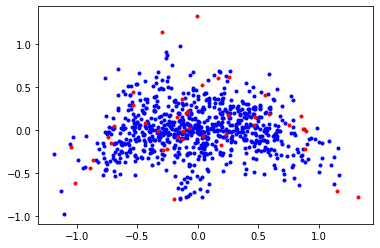

In [21]:
path = "MonografiaDataScience/tmp/lof_im_Koilocytotic.csv"
plot_distribution(path)

**Clase Dyskeratotic**

Existen 41 outliers de 813 datos


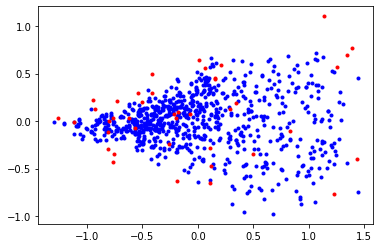

In [22]:
path = "MonografiaDataScience/tmp/lof_im_Dyskeratotic.csv"
plot_distribution(path)

**Clase Metaplastic**

Existen 40 outliers de 793 datos


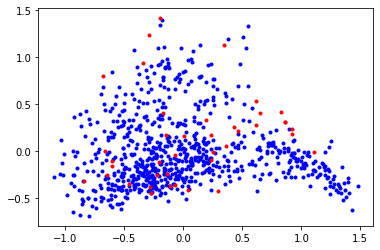

In [23]:
path = "MonografiaDataScience/tmp/lof_im_Metaplastic.csv"
plot_distribution(path)

**Clase Parabasal**

Existen 40 outliers de 787 datos


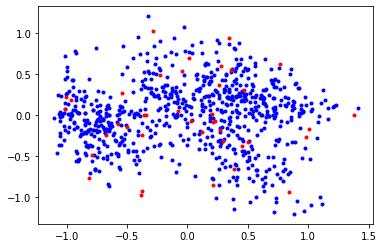

In [24]:
path = "MonografiaDataScience/tmp/lof_im_Parabasal.csv"
plot_distribution(path)

**Clase Superficial-Intermediate**

Existen 42 outliers de 831 datos


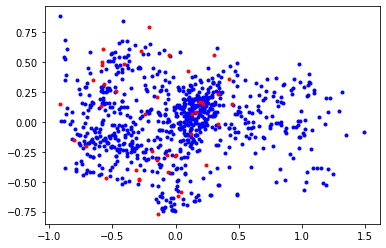

In [25]:
path = "MonografiaDataScience/tmp/lof_im_Superficial-Intermediate.csv"
plot_distribution(path)